In [1]:
# Imports necessary for the project
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

Data Collection and Cleaning

In [ ]:
from google.colab import files
uploaded = files.upload()

In [4]:
workers = pd.read_csv("cleaned_data.csv")

In [ ]:
# Keep workers who are in the working-age between 18 to 65.
workers = df[df["AGE"].between(18, 65)]

# Keep only employed individuals
workers = workers.query("EMPSTAT == 10")

# Replace default values with np.nan
workers.loc[:, 'HOURWAGE'] = workers['HOURWAGE'].replace(999.99, np.nan)
workers.loc[:, 'UHRSWORKT'] = workers['UHRSWORKT'].replace([997, 998, 999], np.nan)
workers.loc[:, 'INCWAGE'] = workers['INCWAGE'].replace(9999999, np.nan)

# Construct hourly wages for the workers
workers["hourly_wage"] = np.where(
    (workers["PAIDHOUR"] == 1) & (~workers["HOURWAGE"].isna()),
    workers["HOURWAGE"],
    workers["INCWAGE"] / (workers["UHRSWORKT"] * 52)
)

# Drop invalid/NaN hourly wages
workers = workers.dropna(subset=["hourly_wage"])

# Keep only the columns mentioned in my initial document:
keep_cols = [
    'SEX', 'RACE', 'AGE', 'EDUC', 'UHRSWORKT', 'hourly_wage', 'INCWAGE'
]
workers = workers[keep_cols]

workers


/var/folders/zw/1p1g2scn1llcnl481zdq41wm0000gn/T/ipykernel_39975/2974635011.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[40. 48. 44. ... 40. 35. nan]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  workers.loc[:, 'UHRSWORKT'] = workers['UHRSWORKT'].replace([997, 998, 999], np.nan)


,SEX,RACE,AGE,EDUC,UHRSWORKT,hourly_wage,INCWAGE
0,2,100,63,73,40.0,25.240385,52500.0
2,1,100,64,73,48.0,13.621795,34000.0
4,2,100,54,73,44.0,17.482517,40000.0
6,1,100,37,73,21.0,7.714286,8424.0
14,2,100,35,91,40.0,20.192308,42000.0
...,...,...,...,...,...,...,...
4756385,2,200,36,111,40.0,12.019231,25000.0
4756386,1,200,27,73,40.0,14.423077,30000.0
4756388,2,651,35,81,8.0,60.096154,25000.0
4756392,1,100,46,92,40.0,38.461538,80000.0


In [ ]:
# Converting categorical variables (SEX, RACE, EDUC) to labels

map_sex = {1: 'Male', 2: 'Female'}
workers['SEX'] = workers['SEX'].map(map_sex)

map_race = {
    100: 'White',
    200: 'Black',
    300: 'American Indian',
    651: 'Asian',
    652: 'Hawaiian/Pacific Islander',
    801: 'Other',
    802: 'Two or more races'
}
workers['RACE'] = workers['RACE'].map(map_race)

map_edu = {
    31: 'Less than High School',
    32: 'High School Graduate',
    40: 'Some College, No Degree',
    41: 'Associate Degree',
    50: 'Bachelor’s Degree',
    60: 'Master’s Degree',
    70: 'Professional Degree',
    71: 'Doctorate Degree',
    73: 'Bachelor’s Degree',
    81: 'Master’s Degree',
    91: 'Some College, No Degree',
    92: 'Associate Degree',
    111: 'Less than High School'
}
workers['EDUC'] = workers['EDUC'].map(map_edu)

workers

,SEX,RACE,AGE,EDUC,UHRSWORKT,hourly_wage,INCWAGE
0,Female,White,63,Bachelor’s Degree,40.0,25.240385,52500.0
2,Male,White,64,Bachelor’s Degree,48.0,13.621795,34000.0
4,Female,White,54,Bachelor’s Degree,44.0,17.482517,40000.0
6,Male,White,37,Bachelor’s Degree,21.0,7.714286,8424.0
14,Female,White,35,"Some College, No Degree",40.0,20.192308,42000.0
...,...,...,...,...,...,...,...
4756385,Female,Black,36,Less than High School,40.0,12.019231,25000.0
4756386,Male,Black,27,Bachelor’s Degree,40.0,14.423077,30000.0
4756388,Female,Asian,35,Master’s Degree,8.0,60.096154,25000.0
4756392,Male,White,46,Associate Degree,40.0,38.461538,80000.0


In [ ]:
workers.to_csv("cleaned_data.csv", index=False)

Exploratory Analysis

In [5]:
# Statistics for continuous variables
print(workers.describe())

                 AGE      UHRSWORKT    hourly_wage       INCWAGE
count  299219.000000  299219.000000  299219.000000  2.992190e+05
mean       41.330855      39.931599      30.224410  6.321969e+04
std        12.461130      10.560664      46.104601  8.034638e+04
min        18.000000       1.000000       0.000000  0.000000e+00
25%        31.000000      40.000000      13.000000  2.500000e+04
50%        41.000000      40.000000      22.157191  4.700000e+04
75%        51.000000      40.000000      36.057692  7.700000e+04
max        65.000000     198.000000    9615.384615  2.099999e+06


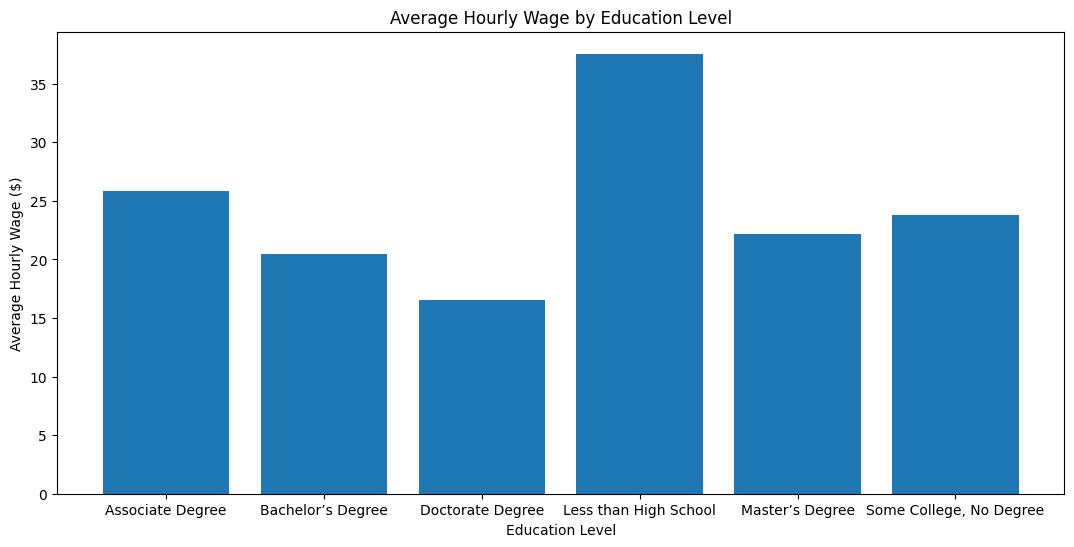

In [6]:
# Wage distribution by education
edu_wage = workers.groupby('EDUC')['hourly_wage'].mean()

plt.figure(figsize=(13,6))
plt.bar(edu_wage.index, edu_wage.values)
plt.title('Average Hourly Wage by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Average Hourly Wage ($)')
plt.savefig("wage_by_education.png")
plt.show()

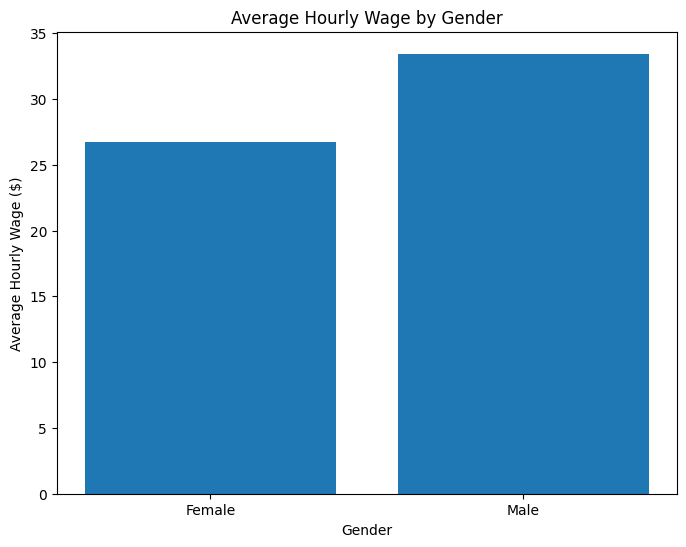

In [7]:
# Wage Distribution by Gender
gender_wage = workers.groupby('SEX')['hourly_wage'].mean()

plt.figure(figsize=(8,6))
plt.bar(gender_wage.index, gender_wage.values)
plt.title('Average Hourly Wage by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Hourly Wage ($)')
plt.savefig("wage_by_gender.png")
plt.show()



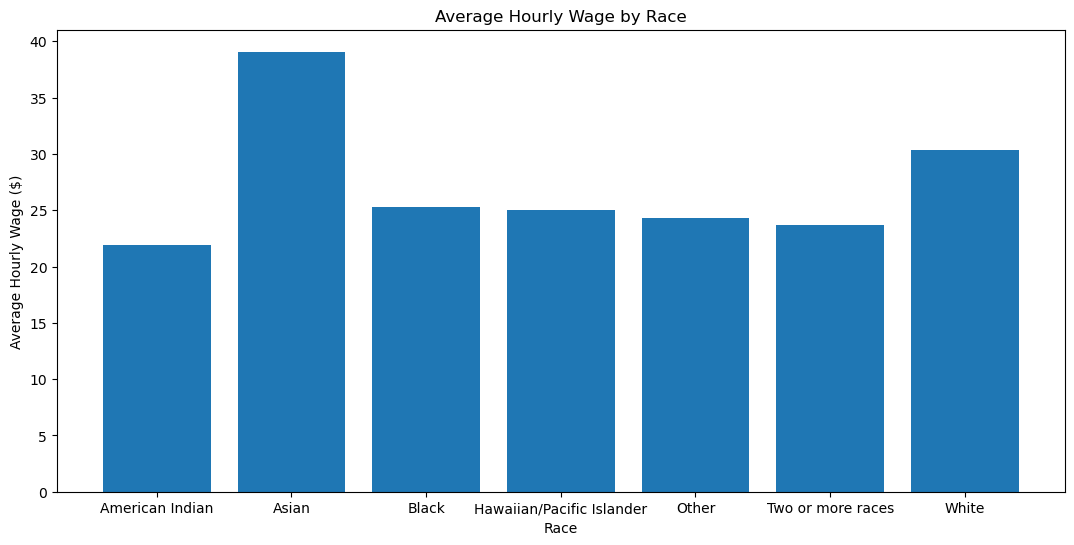

In [ ]:
# Wage Distribution by Race
race_wage = workers.groupby('RACE')['hourly_wage'].mean()

plt.figure(figsize=(13,6))
plt.bar(race_wage.index, race_wage.values)
plt.title('Average Hourly Wage by Race')
plt.xlabel('Race')
plt.ylabel('Average Hourly Wage ($)')
plt.savefig("wage_by_race.png")
plt.show()



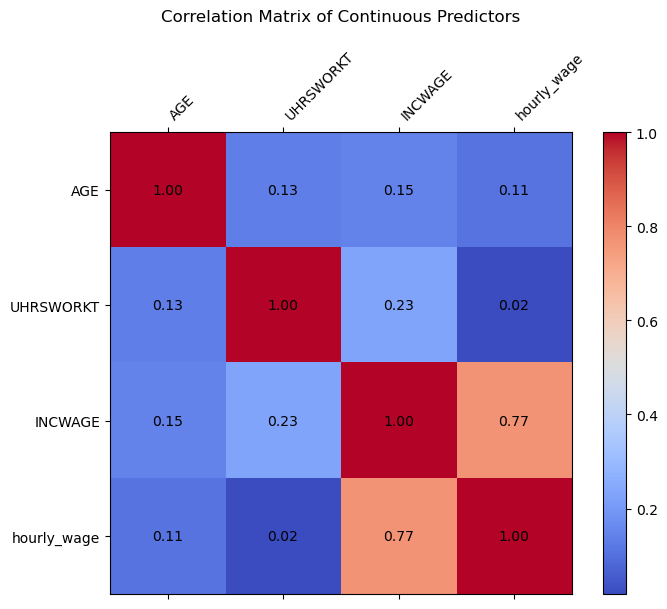

In [ ]:
continuous_vars = ['AGE', 'UHRSWORKT', 'INCWAGE', 'hourly_wage']
corr = workers[continuous_vars].corr()

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(corr, cmap='coolwarm')
fig.colorbar(cax)

# Set axis ticks
ax.set_xticks(np.arange(len(numeric_vars)))
ax.set_yticks(np.arange(len(numeric_vars)))
ax.set_xticklabels(numeric_vars, rotation=45, ha='left')
ax.set_yticklabels(numeric_vars)

# Annotate each cell
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f'{val:.2f}', va='center', ha='center', color='black')

plt.title('Correlation Matrix of Continuous Predictors', pad=20)
plt.savefig("correlation_matrix.png")
plt.show()


Model Building

In [8]:
# Split Data into a training and testing set (80% for training and 20% for testing)
X = workers.drop(columns=["hourly_wage"])
y = workers["hourly_wage"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

X_train = X_train.fillna(0).astype(np.float32)
X_test = X_test.fillna(0).astype(np.float32)

In [9]:
# Training X:
X_train

,AGE,UHRSWORKT,INCWAGE,SEX_Male,RACE_Asian,RACE_Black,RACE_Hawaiian/Pacific Islander,RACE_Other,RACE_Two or more races,RACE_White,EDUC_Bachelor’s Degree,EDUC_Doctorate Degree,EDUC_Less than High School,EDUC_Master’s Degree,"EDUC_Some College, No Degree"
118223,30.0,40.0,31000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
203999,24.0,40.0,29120.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
246312,52.0,40.0,44000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
30360,30.0,40.0,38000.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
239936,32.0,36.0,140000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,57.0,40.0,450000.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
259178,38.0,40.0,70000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
131932,28.0,45.0,20500.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
146867,35.0,60.0,30000.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
# Training Y:
y_train

,hourly_wage
118223,14.903846
203999,14.000000
246312,21.153846
30360,18.269231
239936,74.786325
...,...
119879,216.346154
259178,33.653846
131932,8.760684
146867,9.615385


In [23]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)


In [12]:
print(X_train.dtypes)


AGE                               float32
UHRSWORKT                         float32
INCWAGE                           float32
SEX_Male                          float32
RACE_Asian                        float32
RACE_Black                        float32
RACE_Hawaiian/Pacific Islander    float32
RACE_Other                        float32
RACE_Two or more races            float32
RACE_White                        float32
EDUC_Bachelor’s Degree            float32
EDUC_Doctorate Degree             float32
EDUC_Less than High School        float32
EDUC_Master’s Degree              float32
EDUC_Some College, No Degree      float32
dtype: object


In [14]:
# Neural Network

# Convert to tensors in mini-batches
train_dataset = TensorDataset(
    torch.from_numpy(X_train.values).float(),
    torch.from_numpy(y_train.values).float().unsqueeze(1)
)

test_dataset = TensorDataset(
    torch.from_numpy(X_test.values),
    torch.from_numpy(y_test.values).unsqueeze(1)
)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

class WageNN(nn.Module):
    def __init__(self, input_dim):
        super(WageNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

model = WageNN(X_train.shape[1])

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.MSELoss()

# Training loop
EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 10/100, Loss: 2038.4863
Epoch 20/100, Loss: 1405.6220
Epoch 30/100, Loss: 1106.0684
Epoch 40/100, Loss: 973.1537
Epoch 50/100, Loss: 992.4062
Epoch 60/100, Loss: 969.3735
Epoch 70/100, Loss: 963.4648
Epoch 80/100, Loss: 959.2659
Epoch 90/100, Loss: 954.3470
Epoch 100/100, Loss: 945.4666


In [22]:
# Predict with the neural networok
model.eval()
y_pred_list = []

with torch.no_grad():
    for batch_X, _ in test_loader:
        preds = model(batch_X)
        y_pred_list.append(preds)

# Stacking predictions together
y_pred_nn = torch.vstack(y_pred_list).squeeze().numpy()

Sample Prediction

In [25]:
# made-up person to test on
sample = {
    'AGE': 30,
    'UHRSWORKT': 40,
    'INCWAGE': 60000,
    'SEX_Male': 1,
    'RACE_White': 1,
    'RACE_Asian': 0,
    'RACE_Black': 0,
    'RACE_Hawaiian/Pacific Islander': 0,
    'RACE_Other': 0,
    'RACE_Two or more races': 0,
    'EDUC_Bachelor’s Degree': 1,
    'EDUC_Doctorate Degree': 0,
    'EDUC_Less than High School': 0,
    'EDUC_Master’s Degree': 0,
    'EDUC_Some College, No Degree': 0
}

# Convert the person to data frame
sample_df = pd.DataFrame([sample])
sample_df = sample_df.reindex(columns=X_train.columns, fill_value=0)
sample_df = sample_df.astype(np.float32)

sample_pred_lr = lr.predict(sample_df)[0]
print(f"Linear Regression Predicted Hourly Wage: ${sample_pred_lr:.2f}")

sample_tensor = torch.tensor(sample_df.values, dtype=torch.float32)
model.eval()
with torch.no_grad():
    sample_pred_nn = model(sample_tensor).item()

print(f"Neural Network Predicted Hourly Wage: ${sample_pred_nn:.2f}")

Linear Regression Predicted Hourly Wage: $28.79
Neural Network Predicted Hourly Wage: $21.81


In [28]:
# Compare with the actual data:
matches = workers[
    (workers['AGE'] == 30) &
    (workers['SEX'] == 'Male') &
    (workers['RACE'] == 'White') &
    (workers['EDUC'] == "Bachelor’s Degree") &
    (workers['UHRSWORKT'] == 40)
]

# print(matches[['hourly_wage', 'AGE', 'SEX', 'RACE', 'EDUC', 'UHRSWORKT']])

actual_mean_wage = matches['hourly_wage'].mean()
print(f"Average Actual Hourly Wage for this group: ${actual_mean_wage:.2f}")

Average Actual Hourly Wage for this group: $22.48


Model Evaluation

In [21]:
# RMSE: Root Mean Squared Error; Measures the size of a model's mistakes. Penalizes big errors more.
# MAE: Mean Absolute Error; Measures the average size of mistakes.
# R^2 Score: Measures how much of the variation in wages the model can explain.

# Linear Regression:
print("Linear Regression Results:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("R2 Score:", r2_score(y_test, y_pred_lr))

# Neural Network
print("\nNeural Network Evaluation:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_nn)))
print("MAE:", mean_absolute_error(y_test, y_pred_nn))
print("R2 Score:", r2_score(y_test, y_pred_nn))

Linear Regression Results:
RMSE: 22.37045928574823
MAE: 4.717570898586781
R2 Score: 0.7101722005357027

Neural Network Evaluation:
RMSE: 23.6164387929695
MAE: 6.90736361007753
R2 Score: 0.676987702396861


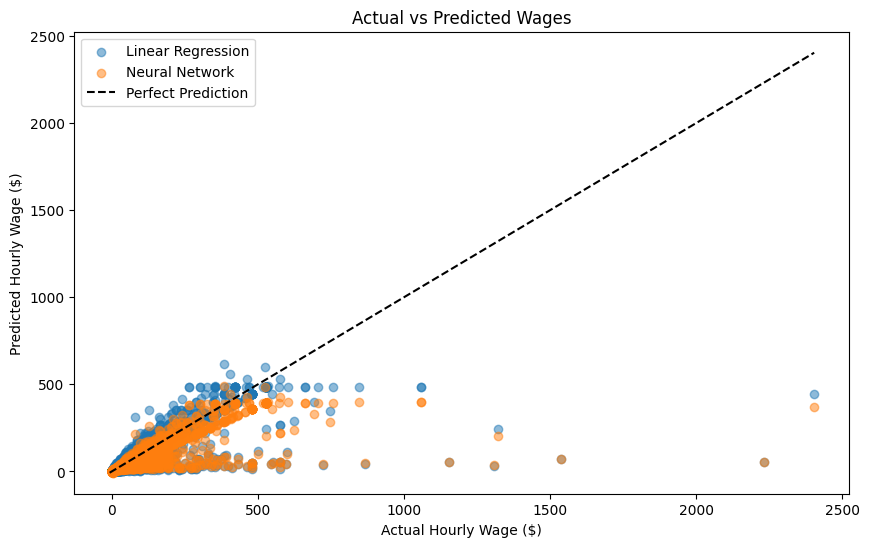

In [30]:
# Plot
plt.figure(figsize=(10,6))

# Linear Regression
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Linear Regression')

# Neural Network
plt.scatter(y_test, y_pred_nn, alpha=0.5, label='Neural Network')

# Perfect prediction line
min_val = min(y_test.min(), y_pred_lr.min(), y_pred_nn.min())
max_val = max(y_test.max(), y_pred_lr.max(), y_pred_nn.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')

plt.xlabel('Actual Hourly Wage ($)')
plt.ylabel('Predicted Hourly Wage ($)')
plt.title('Actual vs Predicted Wages')
plt.legend()
plt.show()
